In [16]:
import numpy as np
import pandas as pd
from scipy.stats import qmc
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [17]:
# Define the Eggholder function
def eggholder_function(x, y):
    term1 = -(y + 47) * np.sin(np.sqrt(abs(x / 2 + (y + 47))))
    term2 = -x * np.sin(np.sqrt(abs(x - (y + 47))))
    return term1 + term2

# Function to calculate Euclidean distance between two points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Generate a mesh for the background Eggholder function
x = np.linspace(-512, 512, 100)
y = np.linspace(-512, 512, 100)
X, Y = np.meshgrid(x, y)
Z = eggholder_function(X, Y)

# Sample initial points using Latin hypercube sampling
lhs = qmc.LatinHypercube(d=2)
initial_samples = lhs.random(n=5)
initial_points = qmc.scale(initial_samples, [-512, -512], [512, 512])
initial_values = np.array([eggholder_function(x, y) for x, y in initial_points])

# Train the initial Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=1729)
rf.fit(initial_points, initial_values)

# Active learning loop for optimization with adaptive sampling
num_iterations = 1000
tolerance = 0.03
improvement = []



In [18]:
# Perform active learning with adaptive sampling
min_function_values = [np.min(initial_values)]  # Track min function value for each iteration
samples = initial_points
sample_values = initial_values

In [19]:
for iteration in range(num_iterations):
    # Generate new candidate samples using LHS
    new_samples_lhs = lhs.random(n=20)
    new_points = qmc.scale(new_samples_lhs, [-512, -512], [512, 512])

    # Calculate distance score based on Euclidean distances
    distances_to_existing = np.array([[min([euclidean_distance(new_point, sample) for sample in samples]) for new_point in new_points]])
    max_distance = np.max(distances_to_existing)
    distance_scores = 1 - distances_to_existing / max_distance

    # Predict uncertainty score based on RF variance
    variance = np.var([tree.predict(new_points) for tree in rf.estimators_], axis=0)
    uncertainty_scores = 1 - variance / np.max(variance)

        # Predict values for the candidate samples
    predicted_values = rf.predict(new_points)

    # Normalize the predicted values between 0 and 1 using Min-Max normalization
    min_predicted_value = np.min(predicted_values)
    max_predicted_value = np.max(predicted_values)
    predicted_score = (predicted_values - min_predicted_value) / (max_predicted_value - min_predicted_value)
    
   


    # Calculate joint score
    joint_scores = 0.33*distance_scores + 0.33*uncertainty_scores + 0.34*predicted_score

    # Find the index of the point with the maximum joint score
    index_of_max_joint_score = np.argmin(joint_scores)

    # The point with the maximum joint score
    chosen_new_point = new_points[index_of_max_joint_score]

    # Update the model with the new point
    chosen_new_value = np.array([eggholder_function(chosen_new_point[0], chosen_new_point[1])])

    # Update training data
    new_points_all = np.vstack([samples, chosen_new_point])
    new_values_all = np.append(sample_values, chosen_new_value)

    # Sort the values in descending order
    new_values_all.sort()

    # Keep track of the minimum function value observed so far
    min_function_values.append(np.min(np.hstack((initial_values, new_values_all))))

    # Re-fit the model including the new points
    rf.fit(new_points_all, new_values_all)

    # Calculate improvement
    rmse = (mean_squared_error(new_values_all, rf.predict(new_points_all)))**0.5
    improvement.append(rmse)

    print(f"Iteration {iteration+1}, RMSE: {rmse}")

    # Check for convergence (change in func value less than the tolerance)
    if len(improvement) > 1 and abs(improvement[-2]-improvement[-1]) <= tolerance:
        print(f"Convergence reached at iteration {iteration+1}.")
        break

    # Update the sample points and values for the next iteration
    samples = new_points_all
    sample_values = new_values_all

Iteration 1, RMSE: 158.873683940144
Iteration 2, RMSE: 218.3604912075598
Iteration 3, RMSE: 229.12924433889893
Iteration 4, RMSE: 234.906784002181
Iteration 5, RMSE: 243.2454533435275
Iteration 6, RMSE: 234.26917016731755
Iteration 7, RMSE: 236.41540455408864
Iteration 8, RMSE: 254.62334374273783
Iteration 9, RMSE: 203.93776663040504
Iteration 10, RMSE: 177.95019080405464
Iteration 11, RMSE: 224.72763133696077
Iteration 12, RMSE: 151.7067617269298
Iteration 13, RMSE: 182.17960280214064
Iteration 14, RMSE: 169.9491699909124
Iteration 15, RMSE: 151.80420524756934
Iteration 16, RMSE: 209.69305088029873
Iteration 17, RMSE: 170.32121237315582
Iteration 18, RMSE: 142.7177415720251
Iteration 19, RMSE: 165.4210285880207
Iteration 20, RMSE: 147.69324806082324
Iteration 21, RMSE: 150.8432154191912
Iteration 22, RMSE: 154.14177252865935
Iteration 23, RMSE: 161.20453075593954
Iteration 24, RMSE: 169.4206999648734
Iteration 25, RMSE: 161.47816147560312
Iteration 26, RMSE: 175.4606323705337
Iteratio

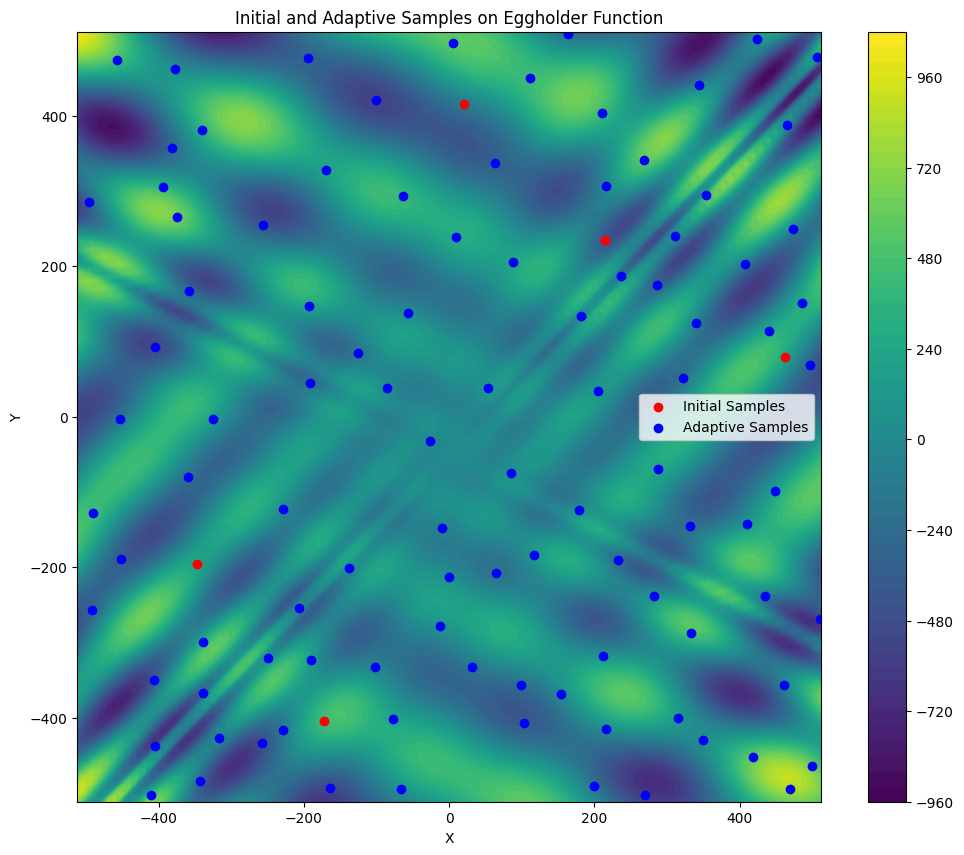

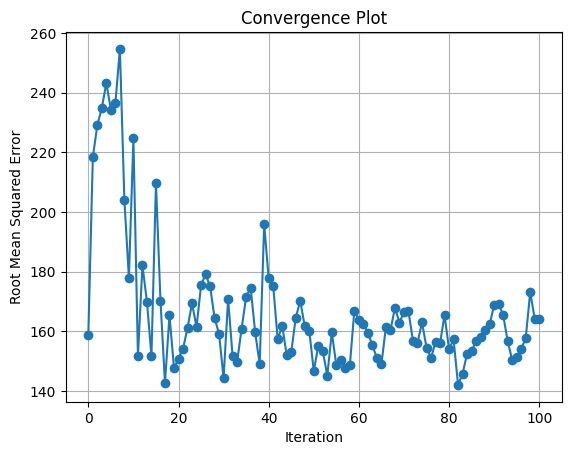

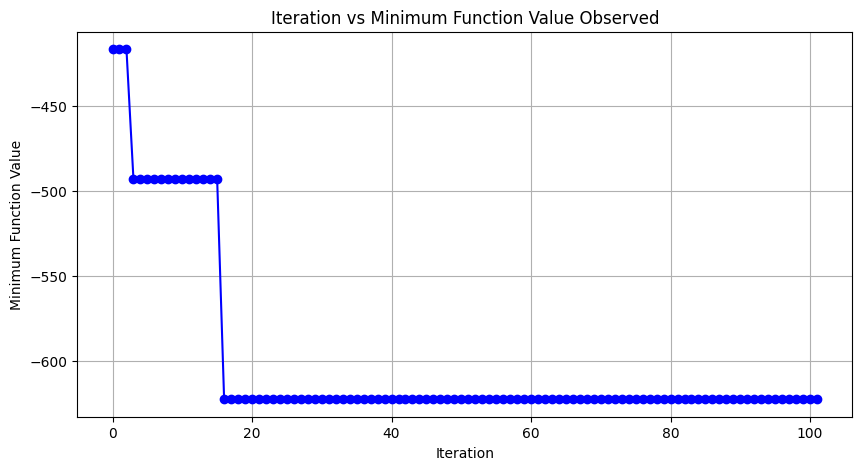

Best observed function value after active learning: -622.4687517668945
             X1          X2
0   -171.903916 -404.284936
1    462.401926   80.085348
2    214.320190  235.112650
3     21.019912  416.233437
4   -347.730567 -195.399206
..          ...         ...
101 -228.703158 -416.419678
102  288.025240  -69.319076
103  153.551497 -369.128281
104  498.924925 -465.107475
105   98.646292 -356.329958

[106 rows x 2 columns]


In [20]:
# Plot initial and final samples
plt.figure(figsize=(12, 10))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar()
plt.scatter(initial_points[:,0], initial_points[:, 1], c='red', label='Initial Samples')
plt.scatter(new_points_all[5:, 0], new_points_all[5:, 1], c='blue', label='Adaptive Samples')
plt.legend()
plt.title('Initial and Adaptive Samples on Eggholder Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot convergence over iterations
plt.figure()
plt.plot(range(len(improvement)), improvement, marker='o')
plt.title('Convergence Plot')
plt.xlabel('Iteration')
plt.ylabel('Root Mean Squared Error')
plt.grid(True)
plt.show()

# Plot iteration vs minimum function values observed
plt.figure(figsize=(10, 5))
plt.plot(min_function_values, marker='o', linestyle='-', color='blue')
plt.title('Iteration vs Minimum Function Value Observed')
plt.xlabel('Iteration')
plt.ylabel('Minimum Function Value')
plt.grid(True)
plt.show()

# Print final result
print(f"Best observed function value after active learning: {min(min_function_values)}")

# Save the final samples to a DataFrame
samples_df = pd.DataFrame({"X1": new_points_all[:,0], "X2": new_points_all[:,1]})
print(samples_df)